In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kamrannaseer","key":"86bfee909777b6a9a32c48d76ca589d5"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d kumaresanmanickavelu/lyft-udacity-challenge

100% 5.11G/5.11G [01:11<00:00, 64.5MB/s]



In [7]:
!mkdir kumaresanmanickavelu

In [8]:
! unzip lyft-udacity-challenge.zip -d kumaresanmanickavelu

Streaming output truncated to the last 5000 lines.
  inflating: kumaresanmanickavelu/datac/dataC/CameraSeg/02_00_004.png  
  inflating: kumaresanmanickavelu/datac/dataC/CameraSeg/02_00_005.png  
  inflating: kumaresanmanickavelu/datac/dataC/CameraSeg/02_00_014.png  
  inflating: kumaresanmanickavelu/datac/dataC/CameraSeg/02_00_015.png  
  inflating: kumaresanmanickavelu/datac/dataC/CameraSeg/02_00_024.png  
  inflating: kumaresanmanickavelu/datac/dataC/CameraSeg/02_00_025.png  
  inflating: kumaresanmanickavelu/datac/dataC/CameraSeg/02_00_034.png  
  inflating: kumaresanmanickavelu/datac/dataC/CameraSeg/02_00_035.png  
  inflating: kumaresanmanickavelu/datac/dataC/CameraSeg/02_00_044.png  
  inflating: kumaresanmanickavelu/datac/dataC/CameraSeg/02_00_045.png  
  inflating: kumaresanmanickavelu/datac/dataC/CameraSeg/02_00_054.png  
  inflating: kumaresanmanickavelu/datac/dataC/CameraSeg/02_00_055.png  
  inflating: kumaresanmanickavelu/datac/dataC/CameraSeg/02_00_064.png  
  inflating: 

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Conv2D, concatenate, Activation, MaxPooling2D, UpSampling2D, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import random
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
base_path = "/content/kumaresanmanickavelu/dataa/dataA/CameraRGB"
seg_path = "/content/kumaresanmanickavelu/dataa/dataA/CameraSeg"
image_paths = os.listdir(base_path)

print(f"Found {len(image_paths)} images!")

Found 1000 images!


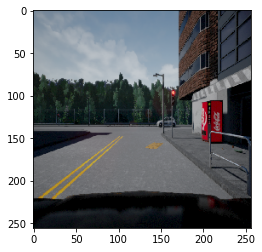

In [4]:
def load_image(path): 
    img = load_img(path, target_size=(256, 256))
    img_arr = img_to_array(img)/255 
    
    return img_arr

index = random.randint(0, len(image_paths))
img = load_image(os.path.join(base_path, image_paths[index]))
plt.imshow(img)

Text(0.5, 1.0, 'Image Mask')

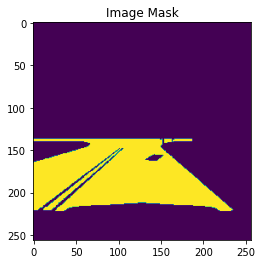

In [5]:
def load_mask(path):
    mask = load_image(path)*255
    mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(mask.shape[0], mask.shape[1])
    mask = np.where(mask == 7, 1, 0)
    return mask

mask = load_mask(os.path.join(seg_path, image_paths[index]))
plt.imshow(mask)
plt.title("Image Mask")

In [6]:
def unet(pretrained_weights = None,input_size = (256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [7]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

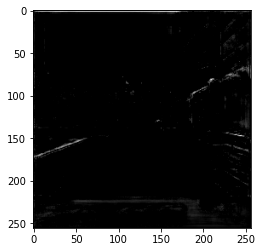

In [8]:
pred = model(np.expand_dims(img, axis=0))
plt.imshow(pred[0,:,:,0], cmap="gray")

In [9]:
images = np.zeros((len(image_paths), 256, 256, 3))
masks = np.zeros((len(image_paths), 256, 256, 1))

for idx, path in enumerate(image_paths): 
    images[idx] = load_image(os.path.join(base_path, path))
    masks[idx,:,:,0] = load_mask(os.path.join(seg_path, path))

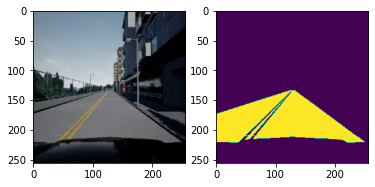

In [10]:
fig, axs = plt.subplots(1, 2)

index = random.randint(0, len(image_paths))
axs[0].imshow(images[index])
axs[1].imshow(masks[index,:,:,0])

In [11]:
# Convert to tensors for GPU optimization 
images = tf.convert_to_tensor(images)
masks = tf.convert_to_tensor(masks)

In [ ]:
model.fit(images, masks, epochs=60, batch_size=32)

Epoch 1/60


In [ ]:
index = random.randint(0, len(image_paths))

pred = model(np.expand_dims(images[index], axis=0))
fig, axs = plt.subplots(1, 3, figsize=(16, 16))
axs[0].imshow(images[index])
axs[1].imshow(masks[index,:,:,0])
axs[2].imshow(pred[0,:,:,0])

axs[0].set_title("Input Image")
axs[1].set_title("Ground Truth")
axs[2].set_title("Predicted Mask")

In [1]:
!kill %N

/bin/bash: line 0: kill: %N: no such job
